# Dự đoán giá sách
***

## Thông tin tập dữ liệu


- Nguồn: Được crawl từ Tiki.vn <br>
- Kích thước tập dữ liệu: 1069x13 <br>
- Tập dữ liệu bao gồm thông tin các mặt hàng sách bán online tại Tiki.vn


## Tiến hành xử lý dữ liệu

Import các thư viện


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import math


Đọc dữ liệu từ file

In [5]:
data = pd.read_csv('./book_data_crawled.csv')
# Loại bỏ kí tự không cần thiết
data['Current Price'] = data['Current Price'].str[:-2].str.replace(".","")
data['Origin Price'] = data['Origin Price'].str[:-2].str.replace(".","")
data['Paper Size'] = data['Paper Size'].str.replace(" ","").str.replace("cm","")
data['Sales'] = data['Sales'].str.replace("+","")

# Chuyển về kiểu dữ liệu số
data['Current Price'] = pd.to_numeric(data['Current Price'])
data['Origin Price'] = pd.to_numeric(data['Origin Price'])
data['Num Pages'] = pd.to_numeric(data['Num Pages'])
data['Sales'] = pd.to_numeric(data['Sales'])

data_origin = data.copy()

data.info()

FileNotFoundError: [Errno 2] No such file or directory: './book_data_crawled.csv'

In [ ]:
data.head(5)

,Title,Sub-category,Category,Author,Seller Name,Current Price,Origin Price,Review Rating,Sales,Publisher,Paper Size,Cover Type,Num Pages
0,Tâm Lý Học Về Tiền,"Sách tài chính, tiền tệ",Sách kinh tế,Morgan Housel,Bookslife,113000,189000,4.8,83,Nhà Xuất Bản Dân Trí,13x20.5,Bìa mềm,384
1,"Think And Grow Rich - 13 Nguyên Tắc Nghĩ Giàu,...",Sách kỹ năng làm việc,Sách kinh tế,Napoleon Hill,Tiki Trading,73700,110000,4.8,1000,Nhà Xuất Bản Lao Động,15.5x24,Bìa mềm,399
2,Dạy Con Làm Giàu (Tập 1) - Để Không Có Tiền Vẫ...,Bài học kinh doanh,Sách kinh tế,Robert T. Kiyosaki,Nhà sách Fahasa,34300,65000,4.9,1000,Công ty phát hành NXB Trẻ,15x20.5,Bìa mềm,193
3,Người Nam Châm (Tái Bản 2019),Sách kỹ năng làm việc,Sách kinh tế,Jack Canfield & DD.Watkins,Tiki Trading,41000,65000,4.8,1000,Công ty phát hành Thái Hà,13x20.5,Bìa mềm,194
4,Chiến Tranh Tiền Tệ - Phần 1 - Ai Thực Sự Là N...,"Sách tài chính, tiền tệ",Sách kinh tế,Song Hong Bing,Tiki Trading,108000,165000,4.9,1000,Nhà Xuất Bản Lao Động,16x24,Bìa mềm,532


### Trích xuất đặc trưng

#### Xử lý dữ liệu trống

In [ ]:
data.isnull().sum()

Title             0
Sub-category      0
Category          0
Author            0
Seller Name      15
Current Price     0
Origin Price      0
Review Rating     0
Sales             0
Publisher         0
Paper Size       14
Cover Type        0
Num Pages         0
dtype: int64

Các đặc trưng Seller Name và Paper Size (đều thuộc kiểu danh mục) có giá trị trống cần xử lý.

Vì số lượng dữ liệu trống ít nên ta tiến hành xử lý bằng cách thay thế bằng danh mục xuất hiện nhều nhất.

In [ ]:
# Giá trị đặc trưng Seller Name xuất hiện nhiều nhất
most_freq_seller_name = data['Seller Name'].mode()
most_freq_seller_name

0    Tiki Trading
Name: Seller Name, dtype: object

In [ ]:
# Giá trị đặc trưng Paper Size xuất hiện nhiều nhất
most_freq_paper_size = data['Paper Size'].mode()
most_freq_paper_size

0    16x24
Name: Paper Size, dtype: object

In [ ]:
# Thay thế giá trị trống
data['Seller Name'] = data['Seller Name'].fillna(most_freq_seller_name[0])
data['Paper Size'] = data['Paper Size'].fillna(most_freq_paper_size[0])
data.isnull().sum()

Title            0
Sub-category     0
Category         0
Author           0
Seller Name      0
Current Price    0
Origin Price     0
Review Rating    0
Sales            0
Publisher        0
Paper Size       0
Cover Type       0
Num Pages        0
dtype: int64

Mã hóa dữ liệu danh mục với Label Encoder

In [ ]:
encoder = LabelEncoder()
for col in ['Sub-category','Category','Author','Seller Name','Publisher','Paper Size','Cover Type']:
    data[col] = encoder.fit_transform(data[col])

data

,Title,Sub-category,Category,Author,Seller Name,Current Price,Origin Price,Review Rating,Sales,Publisher,Paper Size,Cover Type,Num Pages
0,Tâm Lý Học Về Tiền,14,3,419,6,113000,189000,4.8,83,6,11,3,384
1,"Think And Grow Rich - 13 Nguyên Tắc Nghĩ Giàu,...",10,3,424,52,73700,110000,4.8,1000,16,33,3,399
2,Dạy Con Làm Giàu (Tập 1) - Để Không Có Tiền Vẫ...,0,3,591,29,34300,65000,4.9,1000,75,35,3,193
3,Người Nam Châm (Tái Bản 2019),10,3,239,52,41000,65000,4.8,1000,96,11,3,194
4,Chiến Tranh Tiền Tệ - Phần 1 - Ai Thực Sự Là N...,14,3,627,52,108000,165000,4.9,1000,16,42,3,532
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,Ngàn Năm Áo Mũ (Tái Bản),6,2,700,52,192000,320000,4.9,812,23,48,3,400
1065,Đô Thị Cổ Việt Nam,15,2,727,18,132300,189000,4.8,79,12,42,3,432
1066,Đường Mây Qua Xứ Tuyết (Tái Bản),15,2,325,52,86140,118000,4.9,234,23,18,2,320
1067,Phù Thuật Và Tín Ngưỡng An Nam,6,2,511,52,188500,290000,4.8,630,23,48,1,410


Chia dữ liệu thành train set và test set

In [ ]:
X = data.drop(columns=['Title','Current Price'])
y = data['Current Price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=2)


#### Xử lý ngoại lệ trên tập huấn luyện

**Xét các đặc trưng kiểu số Current Price, Origin Price, Review Rating, Sales, Num Pages**

Box Plot

[Text(0.5, 51.0, 'Num Pages'), Text(800.8146551724138, 0.5, 'Số trang')]

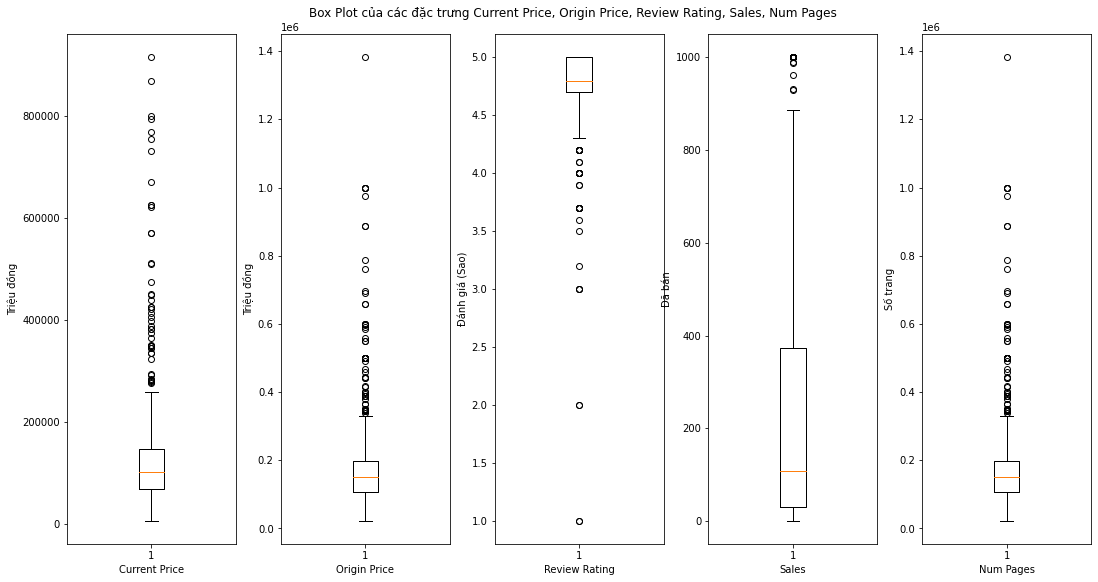

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
fig.set_facecolor('white')
fig.set_figwidth(15)
fig.set_figheight(8)

fig.suptitle('Box Plot của các đặc trưng Current Price, Origin Price, Review Rating, Sales, Num Pages')
fig.tight_layout()

ax1.boxplot(y_train['Current Price'].to_frame())
ax1.set(xlabel='Current Price', ylabel='Triệu đồng')
ax2.boxplot(X_train['Origin Price'])
ax2.set(xlabel='Origin Price', ylabel='Triệu đồng')
ax3.boxplot(X_train['Review Rating'])
ax3.set(xlabel='Review Rating', ylabel='Đánh giá (Sao)')
ax4.boxplot(X_train['Sales'])
ax4.set(xlabel='Sales', ylabel='Đã bán')
ax5.boxplot(X_train['Origin Price'])
ax5.set(xlabel='Num Pages', ylabel='Số trang')

Quan sát phân bố của đặc trưng Current Price, Origin Price, Review Rating, Sales, Num Pages

[Text(0.5, 24.0, 'Num Pages'), Text(800.8146551724138, 0.5, 'Frequency')]

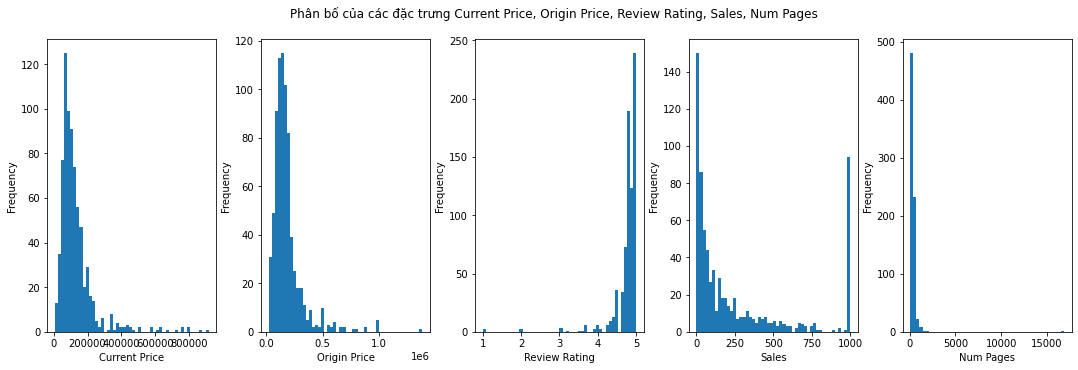

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
fig.set_facecolor('white')
fig.set_figwidth(15)
fig.set_figheight(5)

fig.suptitle('Phân bố của các đặc trưng Current Price, Origin Price, Review Rating, Sales, Num Pages')
fig.tight_layout()

ax1.hist(y_train['Current Price'].to_frame(), bins=50)
ax1.set(xlabel='Current Price', ylabel='Frequency')
ax2.hist(X_train['Origin Price'], bins=50)
ax2.set(xlabel='Origin Price', ylabel='Frequency')
ax3.hist(X_train['Review Rating'], bins=50)
ax3.set(xlabel='Review Rating', ylabel='Frequency')
ax4.hist(X_train['Sales'], bins=50)
ax4.set(xlabel='Sales', ylabel='Frequency')
ax5.hist(X_train['Num Pages'], bins=50)
ax5.set(xlabel='Num Pages', ylabel='Frequency')

Các đặc trưng trên trừ Sales đều có khá nhiều giá trị ngoại lệ và đều có dạng phân bố lệch. Đặc trưng Sales tuy có các giá trị ngoài 2 vạch của Box Plot nhưng chiếm số lượng lớn nên không thể coi là giá trị ngoại lệ.

**Tiến hành xử lý ngoại lệ cho cả bốn đặc trưng**

In [3]:
# Biên theo dạng phân bố lệch (Skewed) của thuộc tính Current Price
iqr_current_price = y_train['Current Price'].quantile(0.75) - y_train['Current Price'].quantile(0.25)
current_price_upper_bound = y_train['Current Price'].quantile(0.75) + 3*iqr_current_price

# Biên theo dạng phân bố lệch (Skewed) của thuộc tính Origin Price
iqr_origin_price = X_train['Origin Price'].quantile(0.75) - X_train['Origin Price'].quantile(0.25)
origin_price_upper_bound = X_train['Origin Price'].quantile(0.75) + 3*iqr_origin_price

# Biên theo dạng phân bố lệch (Skewed) của thuộc tính Review Rating
iqr_review_rating = X_train['Review Rating'].quantile(0.75) - X_train['Review Rating'].quantile(0.25)
review_rating_upper_bound = X_train['Review Rating'].quantile(0.75) + 3*iqr_review_rating

# Biên theo dạng phân bố lệch (Skewed) của thuộc tính Num Pages
iqr_num_pages = X_train['Num Pages'].quantile(0.75) - X_train['Num Pages'].quantile(0.25)
num_pages_upper_bound = X_train['Num Pages'].quantile(0.75) + 3*iqr_num_pages

# Thay thế các giá trị ngoại lệ
y_train.loc[y_train['Current Price'] > current_price_upper_bound, 'Current Price'] = current_price_upper_bound
X_train.loc[X_train['Origin Price'] > origin_price_upper_bound, 'Origin Price'] = origin_price_upper_bound
X_train.loc[X_train['Review Rating'] > review_rating_upper_bound, 'Review Rating'] = review_rating_upper_bound
X_train.loc[X_train['Num Pages'] > num_pages_upper_bound, 'Num Pages'] = num_pages_upper_bound


NameError: name 'y_train' is not defined

Phân bố của các đặc trưng sau xử lý ngoại lệ

[Text(0.5, 24.0, 'Num Pages'), Text(763.1684782608696, 0.5, 'Frequency')]

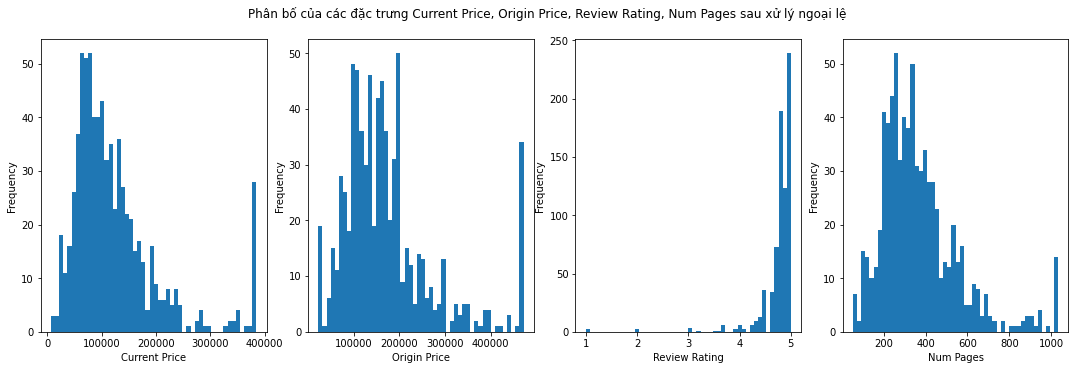

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_facecolor('white')
fig.set_figwidth(15)
fig.set_figheight(5)

fig.suptitle('Phân bố của các đặc trưng Current Price, Origin Price, Review Rating, Num Pages sau xử lý ngoại lệ')
fig.tight_layout()

ax1.hist(y_train['Current Price'], bins=50)
ax1.set(xlabel='Current Price', ylabel='Frequency')
ax2.hist(X_train['Origin Price'], bins=50)
ax2.set(xlabel='Origin Price', ylabel='Frequency')
ax3.hist(X_train['Review Rating'], bins=50)
ax3.set(xlabel='Review Rating', ylabel='Frequency')
ax4.hist(X_train['Num Pages'], bins=50)
ax4.set(xlabel='Num Pages', ylabel='Frequency')

**Nhận xét:** Các giá trị ngoại lệ đã được loại bỏ.

#### Chuẩn hóa dữ liệu huấn luyện

In [17]:
# Chuẩn hóa Min-Max (Min-Max Scaler)
min_max = MinMaxScaler()
X_train = pd.DataFrame(min_max.fit_transform(X_train), columns=X_train.columns)
y_train = pd.DataFrame(min_max.fit_transform(y_train), columns=y_train.columns)

In [18]:
X_train.head(3)

,Sub-category,Category,Author,Seller Name,Origin Price,Review Rating,Sales,Publisher,Paper Size,Cover Type,Num Pages
0,0.294118,1.000000,0.480051,0.812500,0.465479,0.95,0.269269,0.084112,0.365217,0.375,0.488798
1,0.176471,0.333333,0.613900,0.453125,0.472160,1.00,0.003003,0.252336,0.365217,0.375,0.582485
2,0.176471,0.333333,0.908623,0.453125,0.416481,1.00,0.008008,0.252336,0.365217,0.375,0.517312


In [19]:
y_train.head(3)

,Current Price
0,0.424183
1,0.573167
2,0.404463


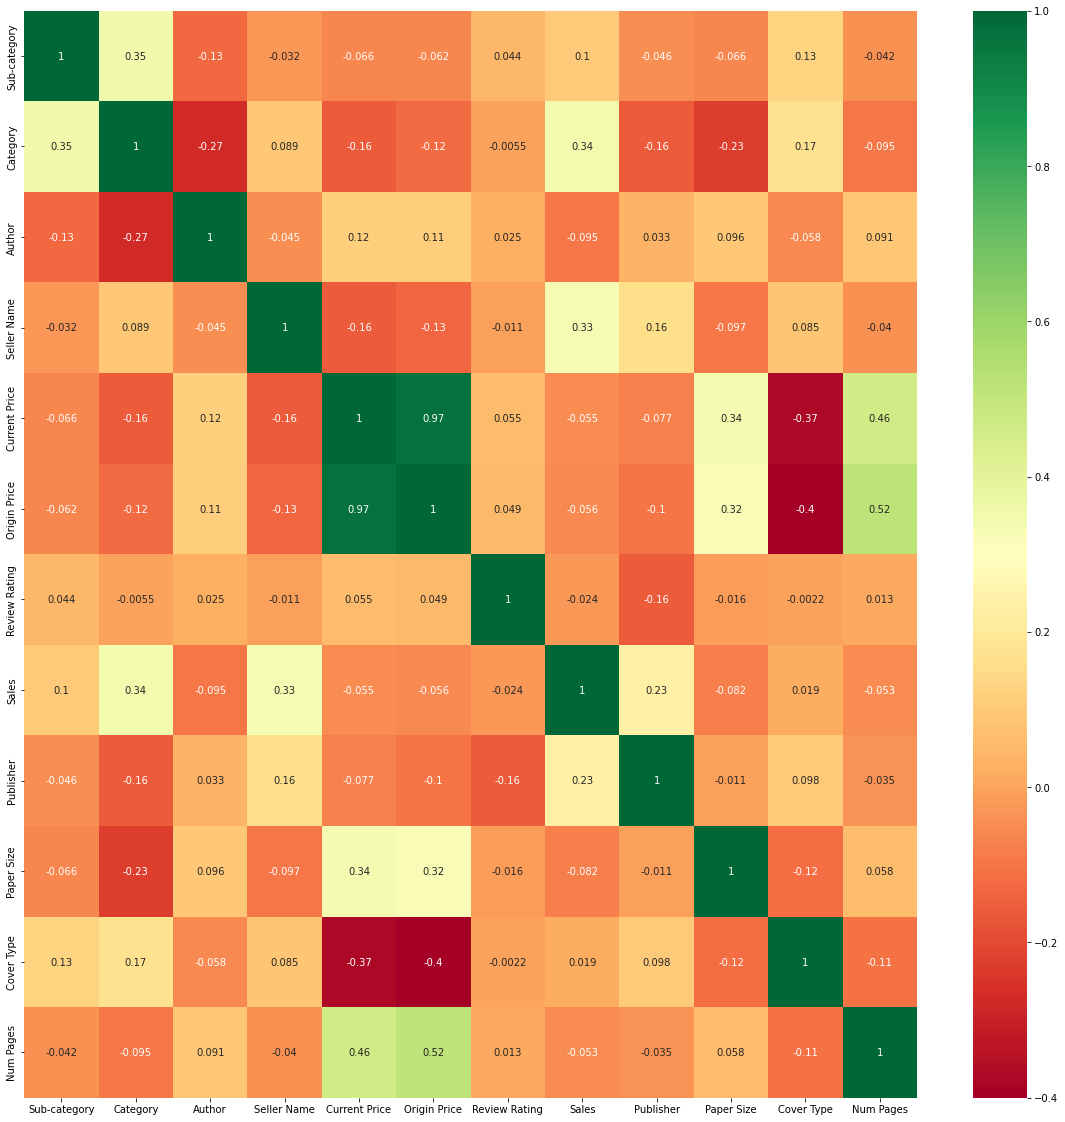

In [20]:
corrmat=data.corr()
top_corr_features=corrmat.index
plt.figure(figsize=(20,20),facecolor='white')
#PLot Heat Map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [406]:
model=ExtraTreesRegressor()
model.fit(X,y)
print(model.feature_importances_)

[0.00743358 0.0082315  0.00535956 0.01096439 0.85330064 0.00501686
 0.00526332 0.00689295 0.01122298 0.01126068 0.07505355]


<AxesSubplot:>

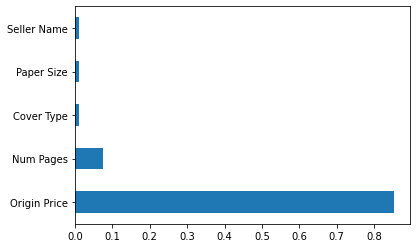

In [408]:
plt.figure(facecolor='white')
feat_importances=pd.Series(model.feature_importances_,index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')

### Mô hình hóa dữ liệu

#### Thống kê mô tả dữ liệu
---

Sử dụng thêm 2 đặc trưng 'Sub-Category' (gọi tắt là category) và 'Region' để tiến hành thống kê phân tích lợi nhuận theo từng ngành hàng và khu vực

##### **Khảo sát đặc trưng Sub-Category**

Trích xuất các giá trị thống kê về tần suất mua hàng và lợi nhuận

In [8]:
categories = data.groupby(['Sub-Category'])

df = pd.DataFrame({
    'Frequency': categories.size(),
    'Profit': categories['Profit'].sum()
})
df.T

Sub-Category,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
Frequency,775.0000,466.0000,796.000,1523.0000,228.000,617.0000,68.0000,254.0000,217.0000,957.0000,364.000,115.0000,1370.0000,889.0000,846.0000,190.0000,319.0000
Profit,41936.6357,18138.0054,6527.787,30221.7633,-3472.556,26590.1663,55617.8249,6964.1767,949.5182,13059.1436,5546.254,3384.7569,34053.5693,44515.7306,21278.8264,-1189.0995,-17725.4811


Vẽ biểu đồ

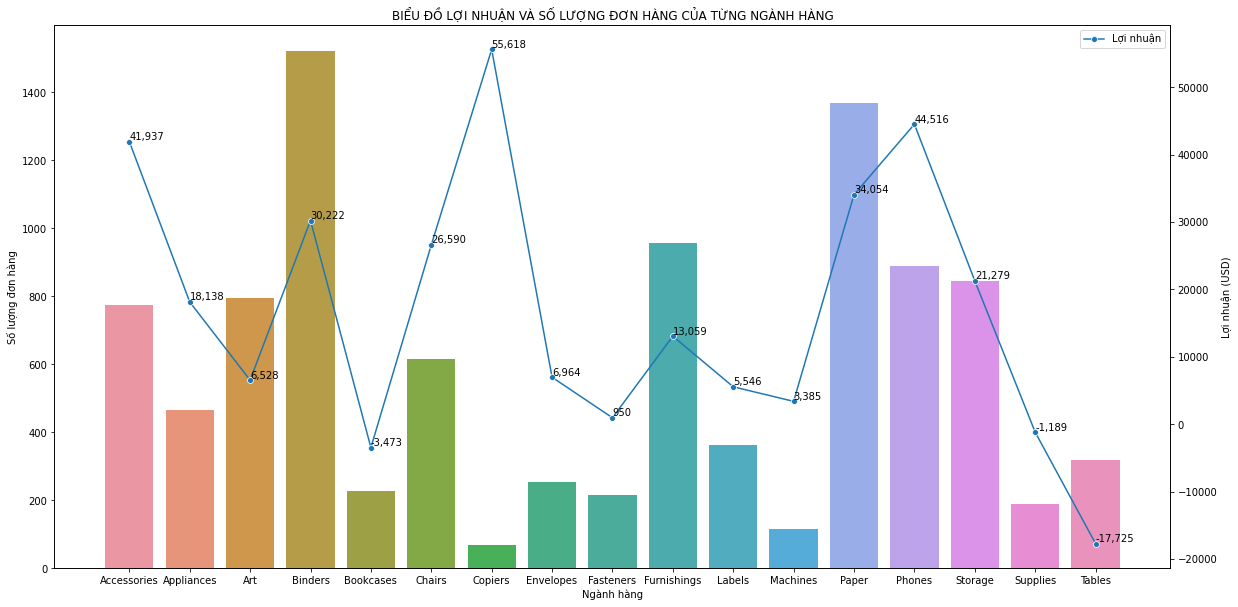

In [9]:
plt.figure(figsize=(20, 10))

sns.barplot(x=list(df.index), y=list(df['Frequency']))

plt.ylabel('Số lượng đơn hàng')
plt.xlabel('Ngành hàng')
plt.twinx()

sns.lineplot(x=list(df.index), y=list(df['Profit']), marker='o')
for i in range(len(categories)):
    plt.text(i , df['Profit'][i], "{:,.0f}".format(df['Profit'][i]), color='k', va ='bottom')
plt.legend(['Lợi nhuận'])
plt.ylabel('Lợi nhuận (USD)')
plt.xlabel('Ngành hàng')
plt.title('BIỂU ĐỒ LỢI NHUẬN VÀ SỐ LƯỢNG ĐƠN HÀNG CỦA TỪNG NGÀNH HÀNG')
plt.show()

Quan sát biểu đồ, dễ dàng thấy được:

- Ngành hàng *Copiers* có số đơn hàng thấp nhất nhưng mang lại doanh thu cao nhất

- 3 ngành hàng *Bookcases*, *Suplies* và *Tables* có lượng đặt hàng không cao, thua lỗ - đặc biệt là *Tables*

- *Binders* và *Papers* là 2 ngành hàng có xu hướng mua sắm tốt và lợi nhuận ổn định

**Kết luận:**

- Cần chú trọng tăng doanh số ngành hàng *Copiers*

- Nên chuẩn bị lượng hàng dồi dào cho 2 ngành *Binders* và *Papers*

- 3 ngành *Bookcases*, *Suplies* và *Tables* nhu cầu thấp, gây thiệt hại về lợi nhuận. Nên tránh kinh doanh những mặt hàng này.

- Các ngành hàng còn lại lợi nhuận tốt và nhu cầu thị trường ổn định 

##### **Khảo sát đặc trưng Region**

Trích xuất các giá trị thống kê về tần suất mua hàng và lợi nhuận

In [10]:
regions = data.groupby(['Region'])

df = pd.DataFrame({
    'Frequency': regions.size(),
    'Profit': regions['Profit'].sum()
})
df.T

Region,Central,East,South,West
Frequency,2323.0000,2848.00,1620.0000,3203.0000
Profit,39706.3625,91522.78,46749.4303,108418.4489


Vẽ biểu đồ

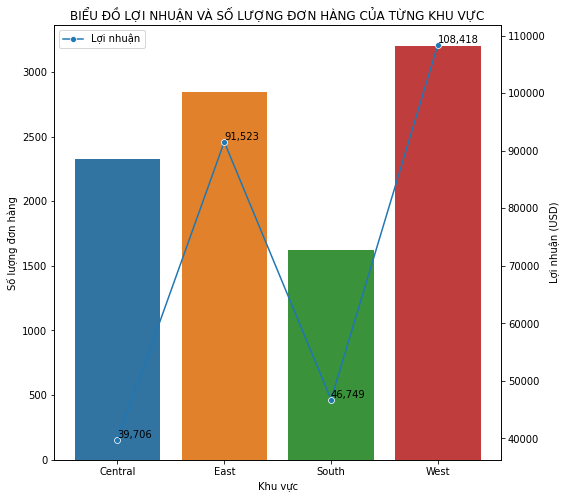

In [11]:
plt.figure(figsize=(8, 8))

sns.barplot(x=list(df.index), y=list(df['Frequency']))
plt.ylabel('Số lượng đơn hàng')
plt.xlabel('Khu vực')
plt.twinx()

sns.lineplot(x=list(df.index), y=list(df['Profit']), marker='o')
for i in range(len(regions)):
    plt.text(i , df['Profit'][i], "{:,.0f}".format(df['Profit'][i]), color='k', va ='bottom')
plt.legend(['Lợi nhuận'])
plt.ylabel('Lợi nhuận (USD)')
plt.xlabel('Khu vực')
plt.title('BIỂU ĐỒ LỢI NHUẬN VÀ SỐ LƯỢNG ĐƠN HÀNG CỦA TỪNG KHU VỰC')
plt.show()

Quan sát biểu đồ, thấy được:

- *West* và *East*  đều có lượng đơn hàng và lợi nhuận cao nhất.

- *Central* và *South* tuy lượng đơn hàng cao nhưng lợi nhuận thu được thấp hơn mức trung bình khá nhiều.

**Kết luận:**

- *West* và *East* là hai thị trường tiềm năng. Cần mở rộng kinh doanh để khai thác tiềm năng.

- *Central* và *South* nhu cầu về các mặt hàng tạo lợi nhuận cao chưa nhiều.

##### **Ma trận tương quan giữa các biến**

In [12]:
corr_matrix = data.corr()
corr_matrix

,Postal Code,Sales,Quantity,Discount,Profit
Postal Code,1.000000,-0.023854,0.012761,0.058443,-0.029961
Sales,-0.023854,1.000000,0.200795,-0.028190,0.479064
Quantity,0.012761,0.200795,1.000000,0.008623,0.066253
Discount,0.058443,-0.028190,0.008623,1.000000,-0.219487
Profit,-0.029961,0.479064,0.066253,-0.219487,1.000000


Vẽ biểu đồ

<AxesSubplot:>

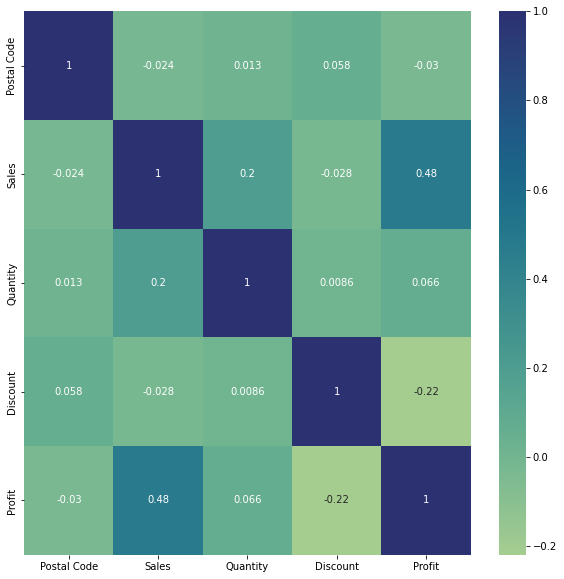

In [13]:
sns.heatmap(corr_matrix, annot=True, cmap='crest')

**Nhận xét:**

Ma trận tương quan cho thấy với các đặc trưng còn lại, chỉ có đặc trưng *Sales* ảnh hưởng đáng kể đến *Profit*.

##### **Khảo sát đặc trưng Sales**

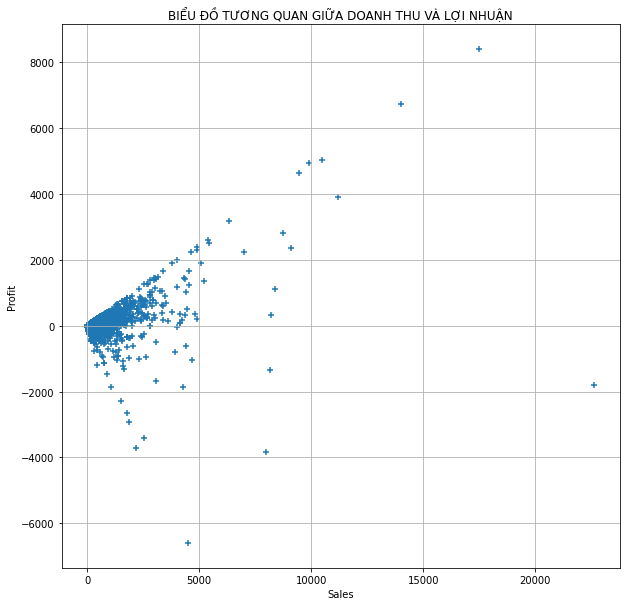

In [14]:
plt.grid()
plt.scatter(x=data['Sales'], y=data['Profit'], marker='+')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.title('BIỂU ĐỒ TƯƠNG QUAN GIỮA DOANH THU VÀ LỢI NHUẬN')
plt.show()

**Nhận xét:**

- Lợi nhuận thu được và phần lỗ có mức độ tập trung cao trong khoảng doanh thu 0-2000

- Doanh thu lớn hơn 5000 thì các phân bố lợi nhuận âm giảm rõ rệt

**Kết luận:**

- Doanh số chính của cửa hàng tập trung trong khoảng 0-2000 USD nhưng lợi nhuận vẫn còn thất thoát khá nhiều.

- Doanh số càng lớn thì lợi nhuận thu được cũng tăng theo.

#### Phân cụm dữ liệu mua sắm

Sử dụng Label Encode cho các dữ liệu danh mục

In [30]:
df = data.copy()
encoder = LabelEncoder()
for col in ['Ship Mode','Quantity','Sub-Category','Category','Region']:
    df[col] = encoder.fit_transform(df[col])

df[['Ship Mode','Quantity','Sub-Category','Category','Region']]

,Ship Mode,Quantity,Sub-Category,Category,Region
0,2,1,4,0,2
1,2,2,5,0,2
2,2,1,10,1,3
3,3,4,16,0,2
4,3,1,14,1,2
...,...,...,...,...,...
9989,2,2,9,0,2
9990,3,1,9,0,3
9991,3,1,13,2,3
9992,3,3,12,1,3


Sử dụng phương pháp chọn K bằng elbow:

    - Distortion: Trung bình cộng phương khoảng cách giữa tâm cụm đến các điểm còn lại.
    - Chọn K mà khi tăng giá trị của nó thì giá trị Distortion cón xu hướng đi ngang hoặc giảm không đáng kể

In [32]:
k = []
for i in range(1,30):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df[['Ship Mode','Quantity','Sales','Profit','Sub-Category','Category','Region']])
    k.append(kmeans.inertia_)

elbow_df = pd.DataFrame(index=range(1,30),data=k).reset_index()
elbow_df = elbow_df.rename(columns={'index':'Number_of_clusters',0:'Sum_of_intra_cluster_squares'})

<AxesSubplot:xlabel='Number_of_clusters', ylabel='Sum_of_intra_cluster_squares'>

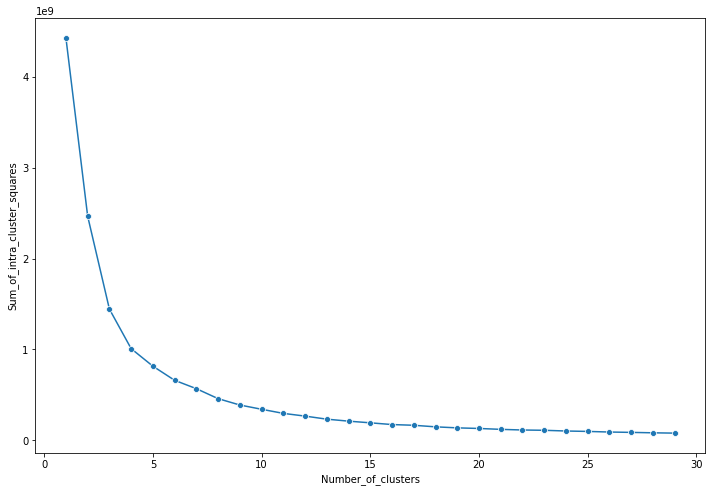

In [45]:
plt.figure(figsize=(12,8))
sns.lineplot(x=elbow_df.Number_of_clusters, y=elbow_df.Sum_of_intra_cluster_squares, marker='o')

-> Chọn k=6

Phân cụm dữ liệu với k=6

In [47]:
kmeans = MiniBatchKMeans(n_clusters=6,
                          random_state=0,
                          batch_size=10)

y_pred = kmeans.fit_predict(df[['Ship Mode','Quantity','Sales','Profit','Sub-Category','Category','Region']])

In [48]:
df_kmeans = df.copy()
df_kmeans['k_means_clusters'] = pd.Series(y_pred)
df_kmeans

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit,k_means_clusters
0,2,Consumer,United States,Henderson,Kentucky,42420,2,FUR-BO-10001798,0,4,261.9600,1,0.00,41.9136,2
1,2,Consumer,United States,Henderson,Kentucky,42420,2,FUR-CH-10000454,0,5,731.9400,2,0.00,219.5820,3
2,2,Corporate,United States,Los Angeles,California,90036,3,OFF-LA-10000240,1,10,14.6200,1,0.00,6.8714,1
3,3,Consumer,United States,Fort Lauderdale,Florida,33311,2,FUR-TA-10000577,0,16,957.5775,4,0.45,-383.0310,3
4,3,Consumer,United States,Fort Lauderdale,Florida,33311,2,OFF-ST-10000760,1,14,22.3680,1,0.20,2.5164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,2,Consumer,United States,Miami,Florida,33180,2,FUR-FU-10001889,0,9,25.2480,2,0.20,4.1028,1
9990,3,Consumer,United States,Costa Mesa,California,92627,3,FUR-FU-10000747,0,9,91.9600,1,0.00,15.6332,4
9991,3,Consumer,United States,Costa Mesa,California,92627,3,TEC-PH-10003645,2,13,258.5760,1,0.20,19.3932,2
9992,3,Consumer,United States,Costa Mesa,California,92627,3,OFF-PA-10004041,1,12,29.6000,3,0.00,13.3200,1


**Biểu đồ phân tán giữa số lượng sản phẩm và doanh thu của đơn hàng**

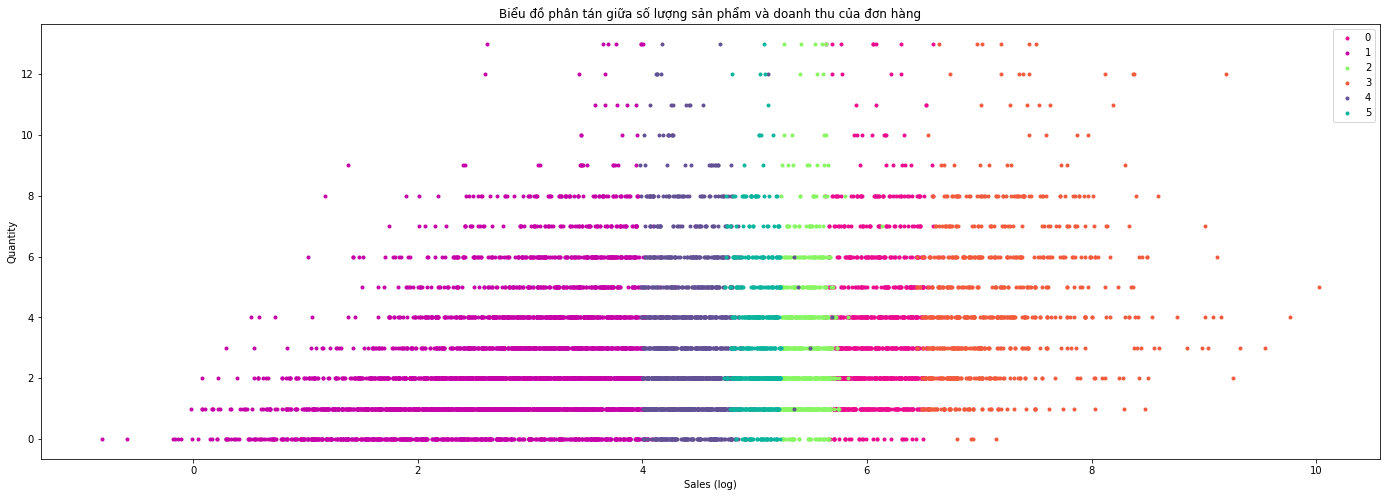

In [76]:
plt.figure(figsize=(24,8))

clusters = df_kmeans['k_means_clusters'].unique()
clusters.sort()

df_kmeans['Sales'] = np.log(df['Sales'])
for i in clusters:
    plt.scatter(x=df_kmeans.loc[df_kmeans['k_means_clusters'] == i, 'Sales'], y=df_kmeans.loc[df_kmeans['k_means_clusters'] == i, 'Quantity'], color=np.random.rand(3,), marker='.')

plt.legend(clusters)
plt.xlabel('Sales (log)')
plt.ylabel('Quantity')
plt.title('Biểu đồ phân tán giữa số lượng sản phẩm và doanh thu của đơn hàng')
plt.show()

*Nhận xét*:
- Các phân cụm phân chia riêng biệt và rõ ràng
- Mức độ tập trung rõ rệt ở các sản phẩm doanh thu thấp được mua với số lượng dày đặc

**Biểu đồ phân tán giữa doanh thu với lợi nhuận**

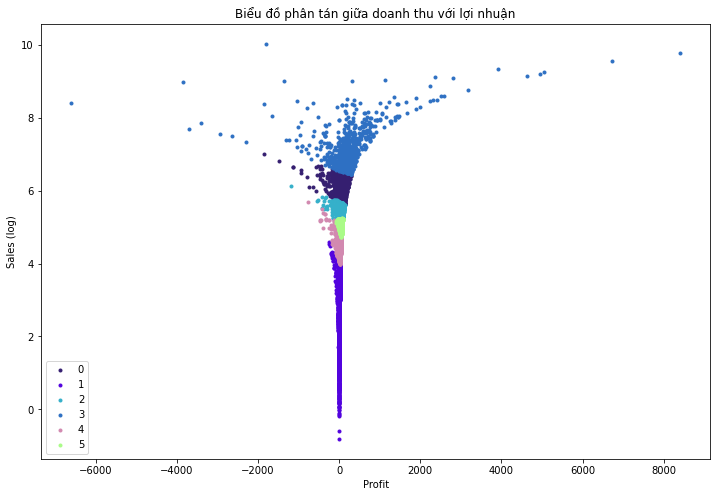

In [77]:
plt.figure(figsize=(12,8))

for i in clusters:
    plt.scatter(x=df_kmeans.loc[df_kmeans['k_means_clusters'] == i, 'Profit'], y=df_kmeans.loc[df_kmeans['k_means_clusters'] == i, 'Sales'], color=np.random.rand(3,), marker='.')

plt.xlabel('Profit')
plt.ylabel('Sales (log)')
plt.title('Biểu đồ phân tán giữa doanh thu với lợi nhuận')
plt.legend(clusters)
plt.show()

*Nhận xét*:
- Chuẩn hóa doanh thu theo logarit làm thể hiện rõ ràng các cụm
- Các khoảng lợi nhuận và doanh thu tương ứng phân bồ tách biệt và không có sự chồng chéo dữ liệu

### HẾT.